In [2]:
#instalar / importar paquetes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import tensorflow as tf

In [4]:
import tensorflow.keras.backend as K
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Conv1D, dot, Dropout
from keras.models import Model
from keras.layers import BatchNormalization  # Modificación realizada aquí
from keras.layers import MaxPooling2D, MaxPooling1D
from keras.layers import Concatenate
from keras.layers import Lambda, Flatten, Dense, Dropout
from keras.initializers import glorot_uniform
from keras.layers import Layer
from keras.regularizers import l2
import os
#from keras import backend as K

In [5]:
seed = 2556
np.random.seed(seed)

In [6]:
data_path = "tcga_common_data_peru.csv"
TCGA_data = pd.read_csv(data_path,sep=',')

In [7]:
TCGA_data.value_counts('labels')

,count
labels,
cancer,373
healthy,50


In [8]:
#selecciona datos de rna_seq_data_common donde labels es cancer
TCGA_data__cancer = TCGA_data[TCGA_data.labels == 'cancer'].sample(70, random_state=seed)
#selecciona 50 datos de rna_seq_data_common donde labels es healthy
TCGA_data_healthy = TCGA_data[TCGA_data.labels == 'healthy'].sample(50, random_state=seed)
#concatena los datos
TCGA_data_balanced = pd.concat([TCGA_data__cancer, TCGA_data_healthy])

In [9]:
#y = TCGA_data_balanced['labels'].values
y = np.where(TCGA_data_balanced['labels'].values == 'cancer', 1, 0)
X = TCGA_data_balanced.drop('labels', axis=1).values

In [10]:
#cuenta la cantidad de valores por clase en y
unique, counts = np.unique(y, return_counts=True)
#impresión de la cantidad de valores por clase
print(np.asarray((unique, counts)).T)

[[ 0 50]
 [ 1 70]]


In [11]:
from sklearn.metrics import accuracy_score, roc_auc_score

def evaluate_model(model):
    pairs_test, targets_test = get_test_pairs()
    predictions = model.predict(pairs_test)
    predictions = predictions.ravel()

    # Calcular métricas
    acc = accuracy_score(targets_test, predictions > 0.5)
    roc_auc = roc_auc_score(targets_test, predictions)

    print(f"Precisión en el conjunto de prueba: {acc:.2f}")
    print(f"ROC-AUC en el conjunto de prueba: {roc_auc:.2f}")

In [12]:
def data_generator(batch_size):
    while True:
        inputs, targets = get_batch(batch_size)
        yield inputs, targets

In [13]:
def get_siamese_model(input_shape, params):
    left_input = Input(shape=input_shape)
    right_input = Input(shape=input_shape)

    # Red Neuronal Convolucional Compartida
    model = Sequential()
    model.add(Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=params['filters'] * 2, kernel_size=params['kernel_size'] // 2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(params['dense_units'], activation='sigmoid'))

    # Generar las codificaciones para las dos entradas
    encoded_l = model(left_input)
    encoded_r = model(right_input)

    # Calcular la distancia absoluta entre las codificaciones
    L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])

    # Añadir una capa final con activación sigmoide
    prediction = Dense(1, activation='sigmoid')(L1_distance)

    # Definir el modelo Siamés
    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)
    return siamese_net




In [14]:
def get_test_pairs(sample_size=1000):
    # Inicializar listas para almacenar los pares y las etiquetas
    pairs = [[], []]
    targets = []

    # Generar índices aleatorios para los pares
    indices = np.random.choice(len(y_test), size=(sample_size, 2), replace=True)

    for idx1, idx2 in indices:
        pairs[0].append(x_test.iloc[idx1].values.reshape(genes_len, 1))
        pairs[1].append(x_test.iloc[idx2].values.reshape(genes_len, 1))
        targets.append(int(y_test[idx1] == y_test[idx2]))

    # Convertir las listas en arrays numpy
    pairs[0] = np.array(pairs[0])
    pairs[1] = np.array(pairs[1])
    targets = np.array(targets)

    return pairs, targets


In [15]:
def get_batch(batch_size, x_data, y_data):
    # Implementación de get_batch utilizando x_data y y_data
    half_batch = batch_size // 2
    pairs = [np.zeros((batch_size, genes_len, 1)) for _ in range(2)]
    targets = np.zeros((batch_size,))
    targets[half_batch:] = 1  # La segunda mitad son pares de la misma clase

    # Obtener índices de muestras de cada clase
    cancer_indices = np.where(y_data == 1)[0]
    non_cancer_indices = np.where(y_data == 0)[0]

    for i in range(half_batch):
        # Pares de clases diferentes
        idx_cancer = np.random.choice(cancer_indices)
        idx_non_cancer = np.random.choice(non_cancer_indices)

        pairs[0][i, :, 0] = x_data.iloc[idx_cancer].values
        pairs[1][i, :, 0] = x_data.iloc[idx_non_cancer].values

    for i in range(half_batch, batch_size):
        # Pares de la misma clase
        if np.random.rand() < 0.5:
            # Ambos cáncer
            if len(cancer_indices) >= 2:
                idx1, idx2 = np.random.choice(cancer_indices, size=2, replace=False)
            else:
                idx1 = idx2 = np.random.choice(cancer_indices)
        else:
            # Ambos no cáncer
            if len(non_cancer_indices) >= 2:
                idx1, idx2 = np.random.choice(non_cancer_indices, size=2, replace=False)
            else:
                idx1 = idx2 = np.random.choice(non_cancer_indices)

        pairs[0][i, :, 0] = x_data.iloc[idx1].values
        pairs[1][i, :, 0] = x_data.iloc[idx2].values

    return pairs, targets

In [16]:
def get_predictions(model, x_data, y_data, sample_size=1000):
    # Inicializar listas para almacenar los pares y las etiquetas
    pairs = [[], []]
    targets = []

    # Generar índices aleatorios para los pares
    indices = np.random.choice(len(y_data), size=(sample_size, 2), replace=True)

    for idx1, idx2 in indices:
        pairs[0].append(x_data.iloc[idx1].values.reshape(genes_len, 1))
        pairs[1].append(x_data.iloc[idx2].values.reshape(genes_len, 1))
        targets.append(int(y_data[idx1] == y_data[idx2]))

    # Convertir las listas en arrays numpy
    pairs[0] = np.array(pairs[0])
    pairs[1] = np.array(pairs[1])
    targets = np.array(targets)

    # Obtener las predicciones del modelo
    predictions = model.predict([pairs[0], pairs[1]])

    return predictions, targets


In [17]:
def evaluate_model(model, x_data, y_data, sample_size=1000):
    # Similar a get_predictions, pero devuelve una métrica (por ejemplo, precisión)
    predictions, targets = get_predictions(model, x_data, y_data, sample_size=sample_size)
    predictions = predictions.ravel()

    # Calcular métricas
    acc = accuracy_score(targets, predictions > 0.5)
    return acc


In [18]:
hyperparameter_grid = {
    'filters': [64], #dejarlo en 64 (32 peores resutlados)
    'kernel_size': [5, 10], #
    'dense_units': [64, 128], #
    'learning_rate': [0.001, 0.0001], #
    'batch_size': [16], # solo 32 y 16 (mejor 16)
    'n_iter': [2000] # early stopping para 2000 paciencia de 50 solo 2000
}
#hacer split
#hacer otro split no hacer cross validations, early stopingpor cada config

In [19]:
import itertools

param_keys = list(hyperparameter_grid.keys())
param_values = list(hyperparameter_grid.values())
param_combinations = [dict(zip(param_keys, values)) for values in itertools.product(*param_values)]

In [20]:
import json
# Cargar las divisiones guardadas desde el archivo
with open('splits.json', 'r') as f:
    splits = json.load(f)

train_indices_list = splits['train']
test_indices_list = splits['test']
n_splits = len(train_indices_list)


In [21]:
# Obtener el checkpoint más reciente
#latest_checkpoint = None
#checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith('.weights.h5')])

#if checkpoint_files:
#    latest_checkpoint_file = checkpoint_files[-1]
#    latest_checkpoint = os.path.join(checkpoint_dir, latest_checkpoint_file)
#    print(f'Último checkpoint encontrado: {latest_checkpoint}')
#    # Obtener el número del pliegue y la iteración del checkpoint
#    current_fold = int(latest_checkpoint_file.split('fold_')[1].split('_ckpt')[0])
#    start_iter = int(latest_checkpoint_file.split('_iter_')[1].split('.weights.h5')[0]) + 1
#else:
##    print('No se encontraron checkpoints en el directorio.')
 #   latest_checkpoint = None
 #   current_fold = 1
 #   start_iter = 1

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

results = []
predictions_per_fold = []

current_fold = 1
current_param_index = 0
checkpoint_root_dir = '/content/drive/My Drive/CancerCiamese/checkpoints/'
# Verificar si hay checkpoints existentes
if os.path.exists(checkpoint_root_dir):
    # Obtener todas las combinaciones de hiperparámetros con checkpoints
    hyperparam_dirs = sorted([d for d in os.listdir(checkpoint_root_dir) if d.startswith('hyperparam_')])

    if hyperparam_dirs:
        # Obtener la última combinación de hiperparámetros entrenada
        latest_hyperparam_dir = hyperparam_dirs[-1]
        current_param_index = int(latest_hyperparam_dir.split('_')[1]) - 1  # Restar 1 porque los índices empiezan en 0

        # Verificar los pliegues dentro de la última combinación de hiperparámetros
        hyperparam_dir = os.path.join(checkpoint_root_dir, latest_hyperparam_dir)
        fold_dirs = sorted([d for d in os.listdir(hyperparam_dir) if d.startswith('fold_')])

        if fold_dirs:
            # Obtener el último pliegue entrenado
            latest_fold_dir = fold_dirs[-1]
            current_fold = int(latest_fold_dir.split('_')[1])
        else:
            current_fold = 1
    else:
        current_param_index = 0
        current_fold = 1
else:
    current_param_index = 0
    current_fold = 1

print(f"Continuando desde combinación de hiperparámetros {current_param_index + 1}, pliegue {current_fold}")


Continuando desde combinación de hiperparámetros 8, pliegue 9


In [24]:
results_dir = '/content/drive/My Drive/CancerCiamese/results'
os.makedirs(results_dir, exist_ok=True)

In [25]:
import pickle  # Para guardar y cargar datos en archivos binarios
# Función para guardar resultados en Google Drive
def save_results_to_drive(results, predictions_per_fold, filename):
    filepath = os.path.join(results_dir, filename)
    with open(filepath, 'wb') as f:
        pickle.dump({'results': results, 'predictions_per_fold': predictions_per_fold}, f)
    print(f"Resultados guardados en {filepath}")

# Función para cargar resultados guardados desde Google Drive
def load_results_from_drive(filename):
    filepath = os.path.join(results_dir, filename)
    if os.path.exists(filepath):
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        print(f"Resultados cargados desde {filepath}")
        return data['results'], data['predictions_per_fold']
    else:
        print(f"No se encontró el archivo {filepath}. Iniciando nuevos resultados.")
        return [], []

In [26]:
# Cargar resultados previos si existen
results, predictions_per_fold = load_results_from_drive('checkpoint_results.pkl')

Resultados cargados desde /content/drive/My Drive/CancerCiamese/results/checkpoint_results.pkl


In [27]:
for param_index, params in enumerate(param_combinations):
    # Verificar si ya existe un resultado para esta combinación de hiperparámetros
    if any(result['params'] == params for result in results):
        print(f"SALTANDO combinación de hiperparámetros {param_index + 1} porque ya fue evaluada.")
        continue  # Saltar combinaciones ya evaluadas

    print(f"\nEvaluando combinación de hiperparámetros {param_index + 1}/{len(param_combinations)}: {params}")
    fold_accuracies = []
    fold_predictions = []

    # Obtener el número de pliegues a entrenar para esta combinación
    for fold in range(1, n_splits + 1):
        print(f"\nEvaluando el pliegue {fold}/{n_splits}")

        # Cargar los índices de entrenamiento y prueba
        train_indices = train_indices_list[fold - 1]
        test_indices = test_indices_list[fold - 1]

        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        # Convertir los datos a DataFrames
        X_train_df = pd.DataFrame(X_train)
        X_test_df = pd.DataFrame(X_test)

        # Selección de características con MI y RFE
        MI = mutual_info_classif(X_train_df, y_train)
        n_features_mi = min(5000, X_train_df.shape[1])  # Asegurar que no excede el número de características
        selected_scores_indices = np.argsort(MI)[::-1][:n_features_mi]

        X_train_mi = X_train_df.iloc[:, selected_scores_indices]
        X_test_mi = X_test_df.iloc[:, selected_scores_indices]

        estimator = linear_model.LogisticRegression(max_iter=700, solver='liblinear')
        n_features_rfe = 60  # Ajustar si es necesario
        rfe = RFE(estimator=estimator, n_features_to_select=n_features_rfe, step=1)
        rfe.fit(X_train_mi, y_train)

        X_train_final = rfe.transform(X_train_mi)
        X_test_final = rfe.transform(X_test_mi)

        scaler = StandardScaler()
        X_train_final = scaler.fit_transform(X_train_final)
        X_test_final = scaler.transform(X_test_final)

        X_train_final = X_train_final.astype('float32')
        X_test_final = X_test_final.astype('float32')

        # Actualizar genes_len e input_shape
        genes_len = X_train_final.shape[1]
        input_shape = (genes_len, 1)

        x_train = pd.DataFrame(X_train_final)
        x_test = pd.DataFrame(X_test_final)

        # Definir y compilar el modelo
        model = get_siamese_model(input_shape, params)
        optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Cargar los pesos del checkpoint
        checkpoint_dir = f'{checkpoint_root_dir}/hyperparam_{param_index+1}/fold_{fold}/'
        checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith('.weights.h5')])

        if checkpoint_files:
            latest_checkpoint_file = checkpoint_files[-1]
            latest_checkpoint = os.path.join(checkpoint_dir, latest_checkpoint_file)
            model.load_weights(latest_checkpoint)
            print(f'Pesos cargados desde {latest_checkpoint}')

            # Evaluar el modelo en el conjunto de validación
            val_acc = evaluate_model(model, x_test, y_test)
            fold_accuracies.append(val_acc)
            print(f"Precisión en validación del pliegue {fold}: {val_acc:.4f}")

            # Obtener predicciones finales en el conjunto de validación
            predictions, targets = get_predictions(model, x_test, y_test)
            fold_predictions.append((predictions, targets))
        else:
            print(f"No se encontraron checkpoints para la combinación {param_index + 1}, pliegue {fold}. Saltando.")

    # Calcular la precisión promedio sobre los pliegues
    avg_accuracy = np.mean(fold_accuracies)
    print(f"Precisión promedio para la combinación {param_index + 1}: {avg_accuracy:.4f}")

    # Almacenar los resultados
    results.append({
        'params': params,
        'accuracy': avg_accuracy
    })

    # Almacenar las predicciones
    predictions_per_fold.append({
        'params': params,
        'predictions': fold_predictions
    })

    # Guardar los resultados actuales en Google Drive
    save_results_to_drive(results, predictions_per_fold, 'checkpoint_results.pkl')

SALTANDO combinación de hiperparámetros 1 porque ya fue evaluada.

Evaluando combinación de hiperparámetros 2/8: {'filters': 64, 'kernel_size': 5, 'dense_units': 64, 'learning_rate': 0.0001, 'batch_size': 16, 'n_iter': 2000}

Evaluando el pliegue 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_2/fold_1/ckpt_fold_1_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Precisión en validación del pliegue 1: 0.7660
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Evaluando el pliegue 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_2/fold_2/ckpt_fold_2_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Precisión en validación del pliegue 2: 0.9280
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Evaluando el pliegue 3/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_2/fold_3/ckpt_fold_3_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Precisión en validación del pliegue 3: 0.6750
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Evaluando el pliegue 4/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_2/fold_4/ckpt_fold_4_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Precisión en validación del pliegue 4: 0.7420
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Evaluando el pliegue 5/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_2/fold_5/ckpt_fold_5_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Precisión en validación del pliegue 5: 0.6260
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Evaluando el pliegue 6/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_2/fold_6/ckpt_fold_6_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Precisión en validación del pliegue 6: 0.6510
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Evaluando el pliegue 7/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_2/fold_7/ckpt_fold_7_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Precisión en validación del pliegue 7: 0.8420
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Evaluando el pliegue 8/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_2/fold_8/ckpt_fold_8_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Precisión en validación del pliegue 8: 0.7570
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Evaluando el pliegue 9/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_2/fold_9/ckpt_fold_9_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Precisión en validación del pliegue 9: 0.8770
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Evaluando el pliegue 10/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_2/fold_10/ckpt_fold_10_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Precisión en validación del pliegue 10: 0.8310
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Precisión promedio para la combinación 2: 0.7695
Resultados guardados en /content/drive/My Drive/CancerCiamese/results/checkpoint_results.pkl

Evaluando combinación de hiperparámetros 3/8: {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'learning_rate': 0.001, 'batch_size': 16, 'n_iter': 2000}

Evaluando el pliegue 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_3/fold_1/ckpt_fold_1_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Precisión en validación del pliegue 1: 0.9530
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Evaluando el pliegue 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_3/fold_2/ckpt_fold_2_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Precisión en validación del pliegue 2: 0.9830
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Evaluando el pliegue 3/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_3/fold_3/ckpt_fold_3_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Precisión en validación del pliegue 3: 0.9880
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Evaluando el pliegue 4/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_3/fold_4/ckpt_fold_4_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Precisión en validación del pliegue 4: 0.9900
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Evaluando el pliegue 5/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_3/fold_5/ckpt_fold_5_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Precisión en validación del pliegue 5: 0.9710
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Evaluando el pliegue 6/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_3/fold_6/ckpt_fold_6_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Precisión en validación del pliegue 6: 1.0000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Evaluando el pliegue 7/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_3/fold_7/ckpt_fold_7_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Precisión en validación del pliegue 7: 1.0000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Evaluando el pliegue 8/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_3/fold_8/ckpt_fold_8_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Precisión en validación del pliegue 8: 0.7870
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Evaluando el pliegue 9/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_3/fold_9/ckpt_fold_9_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Precisión en validación del pliegue 9: 0.9660
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Evaluando el pliegue 10/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_3/fold_10/ckpt_fold_10_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Precisión en validación del pliegue 10: 0.9730
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Precisión promedio para la combinación 3: 0.9611
Resultados guardados en /content/drive/My Drive/CancerCiamese/results/checkpoint_results.pkl

Evaluando combinación de hiperparámetros 4/8: {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'learning_rate': 0.0001, 'batch_size': 16, 'n_iter': 2000}

Evaluando el pliegue 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_4/fold_1/ckpt_fold_1_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Precisión en validación del pliegue 1: 0.7020
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Evaluando el pliegue 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_4/fold_2/ckpt_fold_2_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Precisión en validación del pliegue 2: 0.6630
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Evaluando el pliegue 3/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_4/fold_3/ckpt_fold_3_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Precisión en validación del pliegue 3: 0.6980
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Evaluando el pliegue 4/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_4/fold_4/ckpt_fold_4_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Precisión en validación del pliegue 4: 0.6670
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Evaluando el pliegue 5/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_4/fold_5/ckpt_fold_5_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Precisión en validación del pliegue 5: 0.7780
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Evaluando el pliegue 6/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_4/fold_6/ckpt_fold_6_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Precisión en validación del pliegue 6: 0.7280
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Evaluando el pliegue 7/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_4/fold_7/ckpt_fold_7_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Precisión en validación del pliegue 7: 0.6740
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Evaluando el pliegue 8/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_4/fold_8/ckpt_fold_8_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Precisión en validación del pliegue 8: 0.6200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Evaluando el pliegue 9/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_4/fold_9/ckpt_fold_9_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Precisión en validación del pliegue 9: 0.6770
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Evaluando el pliegue 10/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_4/fold_10/ckpt_fold_10_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Precisión en validación del pliegue 10: 0.5860
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Precisión promedio para la combinación 4: 0.6793
Resultados guardados en /content/drive/My Drive/CancerCiamese/results/checkpoint_results.pkl

Evaluando combinación de hiperparámetros 5/8: {'filters': 64, 'kernel_size': 10, 'dense_units': 64, 'learning_rate': 0.001, 'batch_size': 16, 'n_iter': 2000}

Evaluando el pliegue 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_5/fold_1/ckpt_fold_1_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Precisión en validación del pliegue 1: 0.9380
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Evaluando el pliegue 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_5/fold_2/ckpt_fold_2_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Precisión en validación del pliegue 2: 1.0000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

Evaluando el pliegue 3/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_5/fold_3/ckpt_fold_3_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Precisión en validación del pliegue 3: 1.0000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Evaluando el pliegue 4/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_5/fold_4/ckpt_fold_4_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Precisión en validación del pliegue 4: 1.0000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Evaluando el pliegue 5/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_5/fold_5/ckpt_fold_5_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Precisión en validación del pliegue 5: 1.0000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Evaluando el pliegue 6/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_5/fold_6/ckpt_fold_6_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Precisión en validación del pliegue 6: 1.0000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Evaluando el pliegue 7/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_5/fold_7/ckpt_fold_7_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Precisión en validación del pliegue 7: 1.0000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Evaluando el pliegue 8/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_5/fold_8/ckpt_fold_8_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Precisión en validación del pliegue 8: 0.7600
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Evaluando el pliegue 9/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_5/fold_9/ckpt_fold_9_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Precisión en validación del pliegue 9: 0.9520
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Evaluando el pliegue 10/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_5/fold_10/ckpt_fold_10_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Precisión en validación del pliegue 10: 1.0000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Precisión promedio para la combinación 5: 0.9650
Resultados guardados en /content/drive/My Drive/CancerCiamese/results/checkpoint_results.pkl

Evaluando combinación de hiperparámetros 6/8: {'filters': 64, 'kernel_size': 10, 'dense_units': 64, 'learning_rate': 0.0001, 'batch_size': 16, 'n_iter': 2000}

Evaluando el pliegue 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_6/fold_1/ckpt_fold_1_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Precisión en validación del pliegue 1: 0.8970
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Evaluando el pliegue 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_6/fold_2/ckpt_fold_2_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Precisión en validación del pliegue 2: 0.6660
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Evaluando el pliegue 3/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_6/fold_3/ckpt_fold_3_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Precisión en validación del pliegue 3: 0.7180
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Evaluando el pliegue 4/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_6/fold_4/ckpt_fold_4_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Precisión en validación del pliegue 4: 0.8810
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Evaluando el pliegue 5/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_6/fold_5/ckpt_fold_5_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Precisión en validación del pliegue 5: 0.8730
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Evaluando el pliegue 6/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_6/fold_6/ckpt_fold_6_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Precisión en validación del pliegue 6: 0.8990
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Evaluando el pliegue 7/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_6/fold_7/ckpt_fold_7_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Precisión en validación del pliegue 7: 0.8630
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Evaluando el pliegue 8/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_6/fold_8/ckpt_fold_8_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Precisión en validación del pliegue 8: 0.6860
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Evaluando el pliegue 9/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_6/fold_9/ckpt_fold_9_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Precisión en validación del pliegue 9: 0.5690
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Evaluando el pliegue 10/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_6/fold_10/ckpt_fold_10_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Precisión en validación del pliegue 10: 0.7110
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Precisión promedio para la combinación 6: 0.7763
Resultados guardados en /content/drive/My Drive/CancerCiamese/results/checkpoint_results.pkl

Evaluando combinación de hiperparámetros 7/8: {'filters': 64, 'kernel_size': 10, 'dense_units': 128, 'learning_rate': 0.001, 'batch_size': 16, 'n_iter': 2000}

Evaluando el pliegue 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_7/fold_1/ckpt_fold_1_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Precisión en validación del pliegue 1: 0.9900
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Evaluando el pliegue 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_7/fold_2/ckpt_fold_2_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Precisión en validación del pliegue 2: 1.0000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Evaluando el pliegue 3/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_7/fold_3/ckpt_fold_3_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Precisión en validación del pliegue 3: 0.9480
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Evaluando el pliegue 4/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_7/fold_4/ckpt_fold_4_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Precisión en validación del pliegue 4: 0.9150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Evaluando el pliegue 5/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_7/fold_5/ckpt_fold_5_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Precisión en validación del pliegue 5: 1.0000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Evaluando el pliegue 6/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_7/fold_6/ckpt_fold_6_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Precisión en validación del pliegue 6: 0.9870
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Evaluando el pliegue 7/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_7/fold_7/ckpt_fold_7_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Precisión en validación del pliegue 7: 1.0000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Evaluando el pliegue 8/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_7/fold_8/ckpt_fold_8_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Precisión en validación del pliegue 8: 0.8010
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Evaluando el pliegue 9/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_7/fold_9/ckpt_fold_9_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Precisión en validación del pliegue 9: 0.9670
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Evaluando el pliegue 10/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_7/fold_10/ckpt_fold_10_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Precisión en validación del pliegue 10: 0.9880
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Precisión promedio para la combinación 7: 0.9596
Resultados guardados en /content/drive/My Drive/CancerCiamese/results/checkpoint_results.pkl

Evaluando combinación de hiperparámetros 8/8: {'filters': 64, 'kernel_size': 10, 'dense_units': 128, 'learning_rate': 0.0001, 'batch_size': 16, 'n_iter': 2000}

Evaluando el pliegue 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_8/fold_1/ckpt_fold_1_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Precisión en validación del pliegue 1: 0.8180
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Evaluando el pliegue 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_8/fold_2/ckpt_fold_2_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Precisión en validación del pliegue 2: 0.7060
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Evaluando el pliegue 3/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_8/fold_3/ckpt_fold_3_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Precisión en validación del pliegue 3: 0.7510
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Evaluando el pliegue 4/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_8/fold_4/ckpt_fold_4_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Precisión en validación del pliegue 4: 0.6670
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Evaluando el pliegue 5/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_8/fold_5/ckpt_fold_5_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Precisión en validación del pliegue 5: 0.7090
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Evaluando el pliegue 6/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_8/fold_6/ckpt_fold_6_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Precisión en validación del pliegue 6: 0.6480
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Evaluando el pliegue 7/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_8/fold_7/ckpt_fold_7_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Precisión en validación del pliegue 7: 0.5990
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Evaluando el pliegue 8/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_8/fold_8/ckpt_fold_8_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Precisión en validación del pliegue 8: 0.6980
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Evaluando el pliegue 9/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_8/fold_9/ckpt_fold_9_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Precisión en validación del pliegue 9: 0.7180
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Evaluando el pliegue 10/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Pesos cargados desde /content/drive/My Drive/CancerCiamese/checkpoints//hyperparam_8/fold_10/ckpt_fold_10_iter_50.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Precisión en validación del pliegue 10: 0.7130
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Precisión promedio para la combinación 8: 0.7027
Resultados guardados en /content/drive/My Drive/CancerCiamese/results/checkpoint_results.pkl


In [28]:
# Al finalizar, obtener los mejores hiperparámetros basados en la precisión promedio
best_result = max(results, key=lambda x: x['accuracy'])
print(f"Mejores hiperparámetros: {best_result['params']}, Precisión: {best_result['accuracy']:.4f}")

Mejores hiperparámetros: {'filters': 64, 'kernel_size': 5, 'dense_units': 64, 'learning_rate': 0.001, 'batch_size': 16, 'n_iter': 2000}, Precisión: 0.9718


In [31]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn import linear_model
import tensorflow as tf

# Asumiendo que los datos completos están en X y y
X_train_full = X  # Asegúrate de que X contenga todo el conjunto de datos
y_train_full = y  # Asegúrate de que y contenga todas las etiquetas

# Mejores hiperparámetros encontrados
best_params = {
    'filters': 64,
    'kernel_size': 5,
    'dense_units': 64,
    'learning_rate': 0.001,
    'batch_size': 16,
    'n_iter': 2000
}

In [32]:
# Preprocesamiento completo del conjunto de datos
print("Preprocesando todo el conjunto de datos...")

# Convertir los datos a DataFrames
X_train_df_full = pd.DataFrame(X_train_full)

# Selección de características con MI y RFE
MI_full = mutual_info_classif(X_train_df_full, y_train_full)
n_features_mi = min(5000, X_train_df_full.shape[1])  # Asegurar que no excede el número de características
selected_scores_indices_full = np.argsort(MI_full)[::-1][:n_features_mi]

X_train_mi_full = X_train_df_full.iloc[:, selected_scores_indices_full]

# Aplicar RFE
estimator_full = linear_model.LogisticRegression(max_iter=700, solver='liblinear')
n_features_rfe_full = 60  # Ajusta este número según lo que hiciste durante el entrenamiento
rfe_full = RFE(estimator=estimator_full, n_features_to_select=n_features_rfe_full, step=1)
rfe_full.fit(X_train_mi_full, y_train_full)

X_train_final_full = rfe_full.transform(X_train_mi_full)


Preprocesando todo el conjunto de datos...


In [33]:
# Escalar los datos
scaler_full = StandardScaler()
X_train_final_full = scaler_full.fit_transform(X_train_final_full)
X_train_final_full = X_train_final_full.astype('float32')

# Actualizar genes_len e input_shape
genes_len = X_train_final_full.shape[1]
input_shape = (genes_len, 1)


In [34]:
# Definir el modelo final con los mejores hiperparámetros
print("Construyendo el modelo con los mejores hiperparámetros...")
model = get_siamese_model(input_shape, best_params)

# Compilar el modelo
optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Entrenar el modelo con todo el conjunto de datos
batch_size = best_params['batch_size']
n_iter = best_params['n_iter']

Construyendo el modelo con los mejores hiperparámetros...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
# Configurar el checkpoint para guardar el modelo final
checkpoint_dir = '/content/drive/My Drive/CancerCiamese/final_model/'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'final_model_weights.weights.h5')

In [40]:
# Si X_train_final_full está en formato numpy.ndarray, conviértelo a DataFrame
X_train_final_full_df = pd.DataFrame(X_train_final_full)


In [41]:
# Entrenar el modelo
print("Entrenando el modelo en todo el conjunto de datos...")
for i in range(1, n_iter + 1):
    inputs, targets = get_batch(batch_size, X_train_final_full_df, y_train_full)
    loss, acc = model.train_on_batch(inputs, targets)

    if i % 100 == 0 or i == n_iter:
        # Guardar los pesos del modelo final
        model.save_weights(checkpoint_path)
        print(f"Iteración {i}, pérdida de entrenamiento: {loss:.4f}, precisión: {acc:.4f}, modelo guardado en {checkpoint_path}")

# Guardar el modelo final completo
model.save(os.path.join(checkpoint_dir, 'final_model.h5'))
print(f"Entrenamiento completado. El modelo completo ha sido guardado en {checkpoint_dir}")


Entrenando el modelo en todo el conjunto de datos...
Iteración 100, pérdida de entrenamiento: 0.1226, precisión: 0.9647, modelo guardado en /content/drive/My Drive/CancerCiamese/final_model/final_model_weights.weights.h5
Iteración 200, pérdida de entrenamiento: 0.0886, precisión: 0.9765, modelo guardado en /content/drive/My Drive/CancerCiamese/final_model/final_model_weights.weights.h5
Iteración 300, pérdida de entrenamiento: 0.0701, precisión: 0.9823, modelo guardado en /content/drive/My Drive/CancerCiamese/final_model/final_model_weights.weights.h5
Iteración 400, pérdida de entrenamiento: 0.0579, precisión: 0.9859, modelo guardado en /content/drive/My Drive/CancerCiamese/final_model/final_model_weights.weights.h5
Iteración 500, pérdida de entrenamiento: 0.0494, precisión: 0.9882, modelo guardado en /content/drive/My Drive/CancerCiamese/final_model/final_model_weights.weights.h5
Iteración 600, pérdida de entrenamiento: 0.0432, precisión: 0.9899, modelo guardado en /content/drive/My Dr

Iteración 2000, pérdida de entrenamiento: 0.0159, precisión: 0.9966, modelo guardado en /content/drive/My Drive/CancerCiamese/final_model/final_model_weights.weights.h5
Entrenamiento completado. El modelo completo ha sido guardado en /content/drive/My Drive/CancerCiamese/final_model/


In [42]:
data_path_peru = "data_peru_common_tcga.csv"
peru_data = pd.read_csv(data_path_peru)

In [43]:
peru_data

,OR4F5,SAMD11,KLHL17,PLEKHN1,ISG15,AGRN,TTLL10,B3GALT6,SCNN1D,PUSL1,...,UTY,VCY,CDY2B,HSFY2,KDM5D,RBMY1E,PRY2,CDY1B,DAZ3,labels
0,0.254230,2.141892,2.695940,1.662437,3.167184,3.504840,0.595043,3.111083,2.762887,3.065443,...,3.094987,0.646843,0.203321,0.175602,3.247262,0.379666,0.466016,0.160055,0.225937,cancer
1,-0.011437,1.685124,2.579538,1.466023,3.364204,3.390632,0.235006,3.191572,2.474322,2.871843,...,3.198167,0.090339,0.216779,-0.017372,3.115001,0.036815,0.147280,0.165846,-0.030485,cancer
2,0.362240,2.065399,2.725148,1.525630,3.482724,3.490525,0.566946,3.234901,2.890114,2.958777,...,2.417349,0.627213,0.297323,0.165927,2.882452,0.095503,0.683298,0.220489,0.150972,cancer
3,0.100154,1.764785,2.497702,1.482230,3.155980,3.701021,0.296216,2.973641,2.385950,2.856183,...,0.800008,0.194457,0.157414,-0.072548,0.780398,0.070627,0.036302,0.174238,0.005255,cancer
4,0.165894,2.046008,2.644645,1.799866,3.184813,3.481585,0.571769,3.172657,2.787213,2.987181,...,0.571582,0.951972,0.185237,0.268397,1.105749,0.090594,0.661294,0.170378,0.139097,cancer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0.021198,2.052877,2.502733,1.466716,3.142161,3.320455,0.326255,3.121720,2.440208,2.863108,...,3.191432,0.407765,0.215363,0.197966,3.373025,0.138245,0.186749,0.203355,0.483128,healthy
65,0.380189,2.217285,2.644737,1.702738,3.280922,3.369192,0.458941,3.083183,2.692345,2.992064,...,3.130157,0.681758,0.158950,0.228330,3.252710,0.292829,0.417132,0.178942,0.641082,healthy
66,0.325183,2.201746,2.783097,1.755221,3.416217,3.421884,0.604483,3.017752,2.829693,2.962332,...,0.837612,0.863211,0.321963,0.309608,1.010214,0.308662,0.566428,0.269725,0.322256,healthy
67,0.205764,2.134727,2.729191,1.717289,3.320359,3.389706,0.567399,3.195556,2.664834,2.936403,...,3.091171,1.043533,0.293500,0.317090,3.267150,0.633331,0.797054,0.255759,0.197358,healthy


In [49]:
from sklearn.preprocessing import LabelEncoder

# Selección de características con MI y RFE
X_reserved = peru_data.drop('labels', axis=1)
y_reserved = peru_data['labels']

# Selección de características
X_reserved_mi = X_reserved.iloc[:, selected_scores_indices_full]
X_reserved_final = rfe.transform(X_reserved_mi)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RFE was fitted without feature names
  warnings.warn(


In [54]:
# Guardar la arquitectura del modelo en un archivo JSON
model_json = model.to_json()
with open("/content/drive/My Drive/CancerCiamese/final_model/model_architecture.json", "w") as json_file:
    json_file.write(model_json)


In [51]:
# Ruta donde guardaste el modelo entrenado
checkpoint_dir = '/content/drive/My Drive/CancerCiamese/final_model/'
model_path = os.path.join(checkpoint_dir, 'final_model.h5')

In [64]:
scaler = StandardScaler()
new_data_scaled = scaler.fit_transform(X_reserved_final)

In [65]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Cargar y preparar los nuevos datos
# Suponiendo que `X_reserved_final` es el nuevo conjunto de datos que deseas probar
# y que ya ha sido preprocesado (selección de características y escalado).

# Crear pares de datos para hacer predicciones
def create_pairs_for_prediction(x_data):
    pairs = []

    # Crear pares positivos y negativos para los datos nuevos
    for i in range(len(x_data)):
        for j in range(len(x_data)):
            if i != j:
                pairs.append([x_data[i], x_data[j]])  # Comparar cada muestra con todas las demás

    return np.array(pairs)

# Crear los pares de datos para las predicciones
pairs_new_data = create_pairs_for_prediction(new_data_scaled)

# Dividir los pares en las dos entradas necesarias para el modelo Siamese
input_1 = pairs_new_data[:, 0]
input_2 = pairs_new_data[:, 1]

# Asegurarte de que las dimensiones son correctas
input_1 = np.expand_dims(input_1, axis=-1)
input_2 = np.expand_dims(input_2, axis=-1)

# Hacer las predicciones con el modelo cargado
print("Haciendo predicciones en los nuevos datos...")
predictions = model.predict([input_1, input_2])

# Mostrar los primeros resultados
print("Predicciones completadas. Aquí están las primeras 5 predicciones:")
print(predictions[:5])


Haciendo predicciones en los nuevos datos...
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Predicciones completadas. Aquí están las primeras 5 predicciones:
[[0.99999815]
 [0.9999903 ]
 [0.999826  ]
 [0.9964752 ]
 [0.9996649 ]]


In [69]:
import numpy as np

# Crear etiquetas verdaderas para los pares
def create_true_labels_for_pairs(y_data):
    true_labels = []

    # Comparar las etiquetas de cada par
    for i in range(len(y_data)):
        for j in range(len(y_data)):
            if i != j:
                # Si las etiquetas son iguales, es un par positivo (misma clase), si no, es negativo
                true_labels.append(int(y_data[i] == y_data[j]))

    return np.array(true_labels)

# Suponiendo que 'y_reserved' tiene las etiquetas verdaderas de cada muestra
true_labels = create_true_labels_for_pairs(y_reserved)

# Ver las primeras 5 etiquetas verdaderas
print(true_labels[:5])


[1 1 1 1 1]


In [70]:
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, balanced_accuracy_score

# Definir un umbral para convertir la salida del modelo siames a predicciones binarias
threshold = 0.5
predictions_binary = (predictions >= threshold).astype(int)

# Calcular las métricas
accuracy = accuracy_score(true_labels, predictions_binary)
f1 = f1_score(true_labels, predictions_binary)
mcc = matthews_corrcoef(true_labels, predictions_binary)
balanced_acc = balanced_accuracy_score(true_labels, predictions_binary)

# Mostrar los resultados
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")

Accuracy: 0.5230
F1-score: 0.6172
MCC: 0.0514
Balanced Accuracy: 0.5224


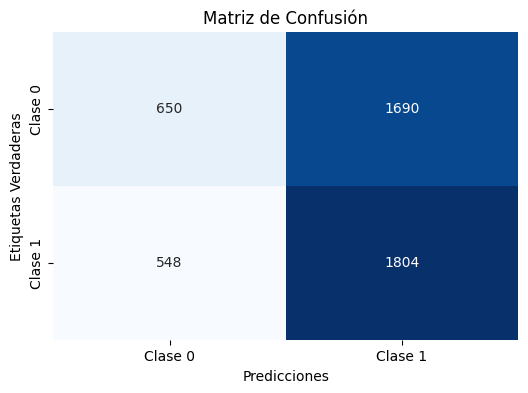

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generar la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predictions_binary)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.xlabel("Predicciones")
plt.ylabel("Etiquetas Verdaderas")
plt.title("Matriz de Confusión")
plt.show()


In [72]:
# Crear pares donde cada muestra se compara consigo misma
def create_self_pairs(x_data):
    pairs = []
    for i in range(len(x_data)):
        pairs.append([x_data[i], x_data[i]])  # Comparar cada muestra consigo misma
    return np.array(pairs)

# Crear los pares de datos para la predicción
self_pairs = create_self_pairs(new_data_scaled)

# Dividir los pares en las dos entradas necesarias para el modelo Siamese
input_1 = self_pairs[:, 0]
input_2 = self_pairs[:, 1]

# Asegurarte de que las dimensiones son correctas
input_1 = np.expand_dims(input_1, axis=-1)
input_2 = np.expand_dims(input_2, axis=-1)

# Hacer las predicciones con el modelo cargado
print("Haciendo predicciones en los nuevos datos comparados consigo mismos...")
predictions = model.predict([input_1, input_2])

# Mostrar las primeras predicciones
print("Predicciones completadas. Aquí están las primeras 5 predicciones:")
print(predictions[:5])


Haciendo predicciones en los nuevos datos comparados consigo mismos...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Predicciones completadas. Aquí están las primeras 5 predicciones:
[[0.5581835]
 [0.5581835]
 [0.5581835]
 [0.5581835]
 [0.5581835]]
